In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import drive
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from tqdm.auto import tqdm
import gc
import keras
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.layers import BatchNormalization,Dropout,Conv1D,Activation,Add,Flatten,Dense
from keras.layers import MaxPooling1D
from keras.layers.merge import concatenate
from keras.initializers import glorot_uniform
from keras.layers import ZeroPadding1D
from keras.models import Input,Model
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight



import warnings 
warnings.filterwarnings('ignore')


drive.mount('/content/drive')

Mounted at /content/drive


## Global variables

In [2]:
data_dirpath = '/content/drive/MyDrive/Colab Notebooks/random_split'

print("Available dataset partitions in this are {}".format(os.listdir(data_dirpath)))

Available dataset partitions in this are ['train', 'dev', 'test']


In [3]:
def read_set(partition):
  """
  Obtaining the data of a partition (train, test or dev) in the form of a dataframe
  """
    all_partition=[]
    for file in os.listdir(os.path.join(data_dirpath,partition)):
        with open(os.path.join(data_dirpath,partition,file)) as f:
            all_partition.append(pd.read_csv(f , index_col=None))
    return pd.concat(all_partition)

def class_joint(data):
      '''
      Pre-processing the class name so as to remove dots 
      '''
      classs = []
      for clas in data['family_accession']:
          x = clas.split('.')
          y = x[0] + str(x[1])
          classs.append(y)
      data['class']=classs
      return data

In [4]:
df_train = class_joint(read_set('train'))
df_dev = class_joint(read_set('dev'))
df_test = class_joint(read_set('test'))

print("Size of dataset train is {} , test is {}, dev is {}".format(len(df_train),len(df_test),len(df_dev)))

Size of dataset train is 1086741 , test is 126171, dev is 126171


In terms of pure volume, the dataset seems well balanced (approximately 80% of samples in the training set, 10% in the dev and test sets)

Checking NaN values

In [5]:
print(len(df_train.dropna()))
print(len(df_dev.dropna()))
print(len(df_test.dropna()))

1086741
126171
126171


No NaN values, the dataset appears to be clean.

In [6]:
df_train['set'] = 'train'
df_dev['set'] = 'set'
df_test['set'] = 'test'

df_all_sets = pd.concat([df_train,df_dev,df_test])

First let's see the distribution of the sizes of the different families across the different sets.

In [7]:
def distribution_family_size(df_partition,partition):
  """
  Displaying the distribution of the family sizes in a set of the dataset or the whole dataset
  """
  df_family_size = pd.DataFrame(df_all_sets.groupby(['family_id','set']).size().reset_index()).rename(columns={0 : 'count'}).sort_values('count',ascending=False)
  
  if partition in ['train','set','test']:
    fig = px.histogram(df_family_size[df_family_size['set'] == partition], x="family_id", y="count",
              color='set', barmode='group',
              height=400)
    fig.show()
  else:
    fig = px.histogram(df_family_size, x="family_id", y="count",
              color='set', barmode='group',
              height=400)
    fig.show()
  
  return None

distribution_family_size(df_all_sets,'train')
distribution_family_size(df_all_sets,'set')
distribution_family_size(df_all_sets,'test')
distribution_family_size(df_all_sets,'all')

## Check if there exists families more numerous in the test or dev set than in train set

In order to check for a balanced repartition of all the families across all sets, one proposes an imbalance metrics which is descibed below in the section.

In [8]:
def f(row):
    """
    Specifying whether a family is imbalanced or not by checking if its train_count attribute is inferior
    to the dev_count attribute or the test_count attribute. 
    """
    if row['train_count'] <= row['dev_count'] or row['train_count'] <= row['test_count']:
        val = 'imbalanced'
    else:
      val = 'normal'
    return val

def get_count_of_the_families(df_partition):
    """
    Counting the the different families in the differents sets and computing an imbalance score
    for both the test and the dev sets.
    """
    df_family_size = pd.DataFrame(df_all_sets.groupby(['family_id','set']).size().reset_index()).rename(columns={0 : 'count'}).sort_values('count',ascending=False)
    new_df_count = pd.DataFrame(index=df_family_size.family_id.unique())
    new_df_count_2 =  new_df_count.join(df_family_size[df_family_size['set'] == 'train'][['family_id','count']].rename(columns={'count' : 'train_count'}).set_index('family_id'))
    new_df_count_3 =  new_df_count_2.join(df_family_size[df_family_size['set'] == 'set'][['family_id','count']].rename(columns={'count' : 'dev_count'}).set_index('family_id'))
    new_df_count_4 =  new_df_count_3.join(df_family_size[df_family_size['set'] == 'test'][['family_id','count']].rename(columns={'count' : 'test_count'}).set_index('family_id'))
    
    
    count_families = new_df_count_4.fillna(0).astype({"dev_count": int,"test_count": int}, errors='raise') 
    
    count_families['imbalanced'] = count_families.apply(f, axis=1)
    count_families['imbalance_score_dev'] = count_families['dev_count'] / count_families['train_count']
    count_families['imbalance_score_test'] = count_families['test_count'] / count_families['train_count']

    return count_families

count_families = get_count_of_the_families(df_all_sets)
display(count_families)
count_families[count_families['imbalanced'] == 'imbalanced']

,train_count,dev_count,test_count,imbalanced,imbalance_score_dev,imbalance_score_test
Methyltransf_25,3637,454,454,normal,0.124828,0.124828
LRR_1,1927,240,240,normal,0.124546,0.124546
Acetyltransf_7,1761,219,219,normal,0.124361,0.124361
His_kinase,1537,192,192,normal,0.124919,0.124919
Bac_transf,1528,190,190,normal,0.124346,0.124346
...,...,...,...,...,...,...
RTBV_P12,1,0,0,normal,0.000000,0.000000
RTBV_P46,1,0,0,normal,0.000000,0.000000
DUF4024,1,0,0,normal,0.000000,0.000000
DUF4014,1,0,0,normal,0.000000,0.000000


,train_count,dev_count,test_count,imbalanced,imbalance_score_dev,imbalance_score_test


17,929 different families are available across the different sets. Every family present in the dev and test sets is also found in the training set. 

In [9]:
count_families[(count_families['imbalance_score_dev'] > 0.2) | (count_families['imbalance_score_test'] > 0.2)]

,train_count,dev_count,test_count,imbalanced,imbalance_score_dev,imbalance_score_test


Every class in the dev and test sets are found in the training set but moreover, every sample in the dev and test sets is a sample that is found at least 5 times more in the training set. The problem for the dataset is that many families found in the training set are under-represented in the dev and test set. 

In [10]:
count_families[(count_families['imbalance_score_dev'] < 0.07) | (count_families['imbalance_score_test'] < 0.07)]

,train_count,dev_count,test_count,imbalanced,imbalance_score_dev,imbalance_score_test
RNA_pol_Rpb1_2,17,1,1,normal,0.058824,0.058824
Replicase,17,1,1,normal,0.058824,0.058824
Mad3_BUB1_II,17,1,1,normal,0.058824,0.058824
PTA_PTB,17,1,1,normal,0.058824,0.058824
Tuberin,17,1,1,normal,0.058824,0.058824
...,...,...,...,...,...,...
RTBV_P12,1,0,0,normal,0.000000,0.000000
RTBV_P46,1,0,0,normal,0.000000,0.000000
DUF4024,1,0,0,normal,0.000000,0.000000
DUF4014,1,0,0,normal,0.000000,0.000000


When the proportions of the dataset are respected :

\begin{align}
imbalance_{test} = \frac{size_{training}}{size_{test}} + \frac{0.8 * size_{dataset}}{0.1 * size_{dataset} }= 0.125
\end{align}

*Note : 80% of the samples for a family should be in the training set while 10% should be in the dev set and the test set).*
 
 However 5,547 families  have a score inferior to 0.07. 
 
Let's be sure that the families concerned by this issue are the least frequent ones. 

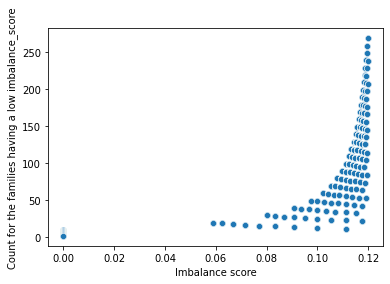

In [11]:
families_imbalanced = count_families[(count_families['imbalance_score_dev'] < 0.12) | (count_families['imbalance_score_test'] < 0.12)]
families_imbalanced['total_count'] = families_imbalanced['train_count'] + families_imbalanced['dev_count'] + families_imbalanced['test_count']

ax = sns.scatterplot(data=families_imbalanced, x="imbalance_score_dev", y="total_count")
ax.set(xlabel='Imbalance score', ylabel='Count for the families having a low imbalance_score')
plt.show()

Looking at the plot, it seems that the families having an imbalance score below 0.11 do not appear more than 100 times in the dataset
The families with the lowest imbalance_score_dev (which is generally equal to the imbalance_score_test even if an average between the two scores should be computed) are definitely families that do not appear many times in the dataset compared to other classes. 
 
At this point, one should talk with biologists or experts who can specify **if the families that are under-represented are families of interest or not**. These families that do not appear many times in the dataset may indeed be families of interest, to tackle this issue some data augmentation should be done. At my point, the performances of the model will not be evaluated for these points. 

The families selected for the training are the ones respecting a good imbalance score and appearing a certain number of times in the training set. This study will compare the performances of the model for different number of families.

In [12]:
families_imbalanced_2 = count_families[(count_families['imbalance_score_dev'] < 0.125) | (count_families['imbalance_score_test'] < 0.125) | (count_families['train_count'] < 25)]

df_train = df_train[~(df_train['family_id'].isin(families_imbalanced_2.index))]
df_dev = df_dev[~(df_dev['family_id'].isin(families_imbalanced_2.index))]
df_test = df_test[~(df_test['family_id'].isin(families_imbalanced_2.index))]

print("New training dataset size : " + str(len(df_train)))
print("New dev dataset size : " + str(len(df_dev)))
print("New test dataset size : " + str(len(df_test)))
print('\n')
print('Proportion of training set in the whole dataset : ' + str(len(df_train) / (len(df_train) + len(df_dev) + len(df_test))))
print('Proportion of dev set in the whole dataset : ' + str(len(df_dev) / (len(df_train) + len(df_dev) + len(df_test))))
print('Proportion of test set in the whole dataset : ' + str(len(df_test) / (len(df_train) + len(df_dev) + len(df_test))))

New training dataset size : 94912
New dev dataset size : 11864
New test dataset size : 11864


Proportion of training set in the whole dataset : 0.8
Proportion of dev set in the whole dataset : 0.1
Proportion of test set in the whole dataset : 0.1


Taking only the families that are in the three datasets.

In [13]:
classes = set.intersection(*map(set,[df_train.family_accession,df_dev.family_accession,df_test.family_accession]))
nb_of_common_classes = len(classes)
print(nb_of_common_classes)

736


All the families in the dev and test sets are now in the training set (it was not the case before the update).

In [14]:
top_frequent_family_train = df_train.groupby('family_accession').size().sort_values(ascending = False).head(nb_of_common_classes).index.to_list()
top_frequent_family_dev = df_dev.groupby('family_accession').size().sort_values(ascending = False).head(nb_of_common_classes).index.to_list()
top_frequent_family_test = df_test.groupby('family_accession').size().sort_values(ascending = False).head(nb_of_common_classes).index.to_list()

classes_2 = set.intersection(*map(set,[top_frequent_family_train,top_frequent_family_dev,top_frequent_family_test]))
print(len(classes_2))

736


In [15]:
most_freq_classes = count_families.head(len(classes_2)).index.to_list()

Storing a dictionary linking the most frequent classes.

In [16]:
import pickle

dictionnary = dict(zip(classes_2,range(len(classes_2))))
with open('multi_class_dict_746.pkl', 'wb') as f:
    pickle.dump(dictionnary, f)

## Balancing the dataset

Unfortunately the number of classes over the number of samples in the dataset is too high. Thus the model will face difficulties finding all correct output. Our solution regarding the context is to reduce the number of class for maximizing the performance of the model regarding standard evaluation metrics (the value of at least 100 training examples for a family seems reasonable for obtaining decent results in the end). Obviously, maximizing the performance of the model will make easier the prediction for common families but one may want to build a model which predict well specific sequences, in this case these classes should be specified beforeward so as to be taken in this phase of the construction of the model.
 
Our hypothesis is that the most common families are the most important one for the model. Our goal will thus be to maximize the performance of the model for these most common families. We could also design a model maximizing the performance on a maximum number of classes. 

After a bit of exploration shows that a family of proteins has the same aligned_sequence length.

In [17]:
df_train['alignment_length'] = df_train.aligned_sequence.str.len()

fig = px.histogram(df_train, x="alignment_length",
               barmode='group',opacity=0.8,
              height=400)
fig.show()

## Same histogram but taking every family one time

families_length_train = (df_train[['family_id', 'alignment_length']]
                  .drop_duplicates()
                  .sort_values(by='alignment_length', ascending=False))

fig = px.histogram(families_length_train, x="alignment_length",opacity=0.8,
               barmode='group',color_discrete_sequence=['red'],
              height=400)
fig.show()

In [18]:
df_train['sequence']=df_train['sequence'].apply(lambda x: x.lower())
df_test['sequence']=df_test['sequence'].apply(lambda x: x.lower())
df_dev['sequence']=df_dev['sequence'].apply(lambda x: x.lower())
df_all_sets['sequence'] = df_all_sets['sequence'].apply(lambda x: x.lower())

def creation_dictionnary(df_total):
    """"
    Creating a dictionnary where the words will be amino acids and the sentences will be the sequences of amino-acids which are proteins. 
    
    """
    dictionnary = []
    for sentence in tqdm(df_total['sequence']):
        for word in sentence:
            if word not in dictionnary:
                dictionnary.append(word)
    return sorted(dictionnary) 

amino_acids_dictionnary = creation_dictionnary(df_all_sets)

  0%|          | 0/1339083 [00:00<?, ?it/s]

Storing the new datasets

In [19]:
df_stored = pd.concat([df_train,df_dev,df_test])
df_stored.to_csv('pfam_746.csv')

Obtaining a dictionnary linking amino acids with a specific index. This dictionnary should be used as input for the config.py file.

In [18]:
def index_char_dict(amino_acids_dictionnary):
    index_to_char_dict = {}
    char_to_index_dict = {}

    for key, value in enumerate(amino_acids_dictionnary):
        index_to_char_dict[key] = value
        char_to_index_dict[value] = key
    return index_to_char_dict,char_to_index_dict    

train_index_char_dict,train_char_index_dict = index_char_dict(amino_acids_dictionnary)

len(train_index_char_dict)

25

The further encoding process is stopped due to memory issue. Let's try to optimize the format of the data. We first see that most of the dtypes of our dataset are object. One should optimize the object dtype for the column sequence to have better performances. Object types optimization using categoricals have been done there but does not seem to optimize the memory storage for the column 'sequence'. 


In [19]:
del count_families
del df_all_sets
gc.collect()

864

## Attempt at memory management

In [20]:
df_train.info(memory_usage='deep')

df_train['sequence'] = df_train['sequence'].astype(str)
df_train['alignment_length'] = pd.to_numeric(df_train['alignment_length'], downcast='unsigned')

sequence = df_train.sequence
sequence_cat = sequence.astype('category')

def mem_usage(pandas_obj):
    """
    Checking the memory usage of a pandas object
    """
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

print(mem_usage(sequence))
print(mem_usage(sequence_cat))

df_train.info(memory_usage='deep')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 104480 entries, 6 to 13599
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   family_id         104480 non-null  object
 1   sequence_name     104480 non-null  object
 2   family_accession  104480 non-null  object
 3   aligned_sequence  104480 non-null  object
 4   sequence          104480 non-null  object
 5   class             104480 non-null  object
 6   set               104480 non-null  object
 7   alignment_length  104480 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 93.7 MB
22.80 MB
27.23 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 104480 entries, 6 to 13599
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   family_id         104480 non-null  object
 1   sequence_name     104480 non-null  object
 2   family_accession  104480 non-null  object
 3   alig

In [21]:
len(train_char_index_dict)

25

## Pre-processing and tokenization

Encoding the sequence of amino-acids into sequence of index using the char_index_dict.

In [22]:
def encoding(partition_df,char_index_dict):
  """
    Tokenizing the amino acids of the sequences in the dataset
    :param df: datframe containing the sequences
    :param char_index_dict: a dictionary with amino-acids:index value
    :return: df where the sequences are updated
  """
  final_string=[]
  for sentence in tqdm(partition_df['sequence']):
      sequence = []
      for word in sentence:
          x=char_index_dict[word]
          sequence.append(str(x))
      final_string.append(sequence)
  partition_df['clean_seq'] = final_string
  
  return partition_df

encoded_sequences_train = encoding(df_train,train_char_index_dict)
encoded_sequences_dev = encoding(df_dev,train_char_index_dict)
encoded_sequences_test = encoding(df_test,train_char_index_dict)


  0%|          | 0/104480 [00:00<?, ?it/s]

  0%|          | 0/13060 [00:00<?, ?it/s]

  0%|          | 0/13060 [00:00<?, ?it/s]

In [24]:
gc.collect()

107

Padding the sequences (adding 0 to sequences that overcome a length of seq_len). seq_len is set to 100 looking at the graph above.

In [25]:
from keras.preprocessing import sequence

def padding(word_index_sequence,seq_len):
   """
   Zero pad the training sequences given the maximum length. This padding is done on left hand side.
   If sequence is > MAX_LEN, it is truncated on left hand side too
   """
    max_sequence_length = seq_len
    final_sequence = sequence.pad_sequences(word_index_sequence , maxlen=max_sequence_length,padding='post')
    return final_sequence

final_train_seq = padding(list(encoded_sequences_train['clean_seq']),100) # most of the families are 100 amino-acids long
final_dev_seq = padding(list(encoded_sequences_dev['clean_seq']),100)
final_test_seq = padding(list(encoded_sequences_test['clean_seq']),100)

One hot encoding for our encoded sequences.

In [26]:
def one_hot(final_sequence):
    '''
    One hot encoding of a sequence of index
    :return: one hot encoded embedding
    '''
    nb_classes = len(train_index_char_dict)
    targets = np.array(final_sequence)
    one_hot_train = np.eye(nb_classes)[targets]
    
    return one_hot_train

train_one_hot = one_hot(final_train_seq)
dev_one_hot = one_hot(final_dev_seq)
test_one_hot = one_hot(final_test_seq)

Saving the final datasets

In [27]:
#np.save('/content/drive/My Drive/Colab Notebooks/archive_protein/final_train_'+ str(len(classes_2)) + '.npy',train_one_hot)
#np.save('/content/drive/My Drive/Colab Notebooks/archive_protein/final_test_' + str(len(classes_2)) + '.npy',test_one_hot)
#np.save('/content/drive/My Drive/Colab Notebooks/archive_protein/final_dev_' + str(len(classes_2)) + '.npy',dev_one_hot)

In [28]:
print(train_one_hot.shape)

(104480, 100, 25)


Encoding the label representing every family.

In [29]:
def label_encoding(partition):
  """
  Encoding the y-label of a dataset into categories given the dataframe of the dataset
  :param df partition : dataframe of the data
  """
  labelencoder = LabelEncoder()
  y_le = labelencoder.fit_transform(partition['class'])

  ylist=[]

  for y in tqdm(y_le):
      Y = keras.utils.np_utils.to_categorical(y,len(labelencoder.classes_))
      ylist.append(Y)

  return np.array(ylist)  

y_train = label_encoding(df_train)
y_validation = label_encoding(df_dev)
y_test = label_encoding(df_test)

  0%|          | 0/104480 [00:00<?, ?it/s]

  0%|          | 0/13060 [00:00<?, ?it/s]

  0%|          | 0/13060 [00:00<?, ?it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


##Keras implementation of the VDCNN. 
The results obtained are very accurate in every cases for PFAM_176. 

In [31]:
input_s = Input(shape=(100,25))

X  = Conv1D(64, 3 , strides=1,padding='valid', name='conv1d_1', kernel_initializer=glorot_uniform(seed=0))(input_s)

X  = MaxPooling1D(pool_size=2)(X)
X1 = BatchNormalization(axis=2, name='batch_normalization_1')(X)

X2 = Activation('relu',name='activation_1')(X1)

X3 = BatchNormalization(axis=2, name='batch_normalization_2')(X2)

X4 = Activation('relu',name='activation_2')(X3)

X5 = Conv1D(64, 1 , strides=1,padding='valid', name='conv1d_3', kernel_initializer=glorot_uniform(seed=0))(X4)

X6 = BatchNormalization(axis=2, name='batch_normalization_3')(X5)

X7 = Activation('relu',name='activation_3')(X6)

X8 = Conv1D(64 , 1 , strides=1 ,padding='valid', name='conv1d_4' , kernel_initializer=glorot_uniform(seed=0))(X7)
X8 = Dropout(0.5,name='d3')(X8)
X8 = MaxPooling1D(pool_size=2)(X8)

X9 = Conv1D(64,  1 , strides=1 ,padding ='valid',name='conv1d_2',  kernel_initializer=glorot_uniform(seed=0))(X2)
X9 = Dropout(0.5,name='d7')(X9)
X9 = MaxPooling1D(pool_size=2)(X9)

X10 = Add()([X8,X9])

X11 = Activation('relu',name='activation_4')(X10)
X11 = Dropout(0.2)(X11)

X12 = BatchNormalization(axis=2,name='batch_normalization_4')(X11)

X13 = Activation('relu',name='activation_5')(X12)

X14 = Dropout(0.5,name='dropout_1')(X13)

X15 = Flatten(name='flatten_1')(X14)

X16 = Dense(len(classes_2) ,name='fc' + str(len(classes_2)), kernel_initializer = glorot_uniform(seed=0))(X15)

X17 = Activation('softmax',name='activation_6')(X16)

model = Model(inputs = input_s, outputs = X17)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history=model.fit(train_one_hot, y_train, epochs=10, batch_size=256 , validation_data=(dev_one_hot,y_validation))

Epoch 1/10
6530/6530 [==============================] - 66s 8ms/step - loss: 3.0215 - accuracy: 0.5385 - precision: 0.9420 - recall: 0.3818 - val_loss: 2.6415 - val_accuracy: 0.8279 - val_precision: 1.0000 - val_recall: 0.0848
Epoch 2/10
6530/6530 [==============================] - 50s 8ms/step - loss: 0.8086 - accuracy: 0.8407 - precision: 0.9467 - recall: 0.7880 - val_loss: 0.8765 - val_accuracy: 0.9119 - val_precision: 0.9995 - val_recall: 0.6509
Epoch 3/10
6530/6530 [==============================] - 51s 8ms/step - loss: 0.4561 - accuracy: 0.9012 - precision: 0.9568 - recall: 0.8725 - val_loss: 0.4482 - val_accuracy: 0.9364 - val_precision: 0.9977 - val_recall: 0.8483
Epoch 4/10
6530/6530 [==============================] - 49s 8ms/step - loss: 0.3351 - accuracy: 0.9234 - precision: 0.9627 - recall: 0.9017 - val_loss: 0.3527 - val_accuracy: 0.9431 - val_precision: 0.9950 - val_recall: 0.8864
Epoch 5/10
6530/6530 [==============================] - 49s 8ms/step - loss: 0.2683 - accura

In [32]:
score = model.evaluate(test_one_hot,y_test , verbose=1)
print("Test loss:",score[0])
print("Test accuracy:",score[1])
print("Test Precision :",score[2])
print("Test Recall :",score[3])

409/409 [==============================] - 2s 5ms/step - loss: 0.2159 - accuracy: 0.9600 - precision: 0.9896 - recall: 0.9419
Test loss: 0.21590232849121094
Test accuracy: 0.9600306153297424
Test Precision : 0.9896218776702881
Test Recall : 0.9418836236000061


In [ ]:
test_preds = model.predict(test_one_hot)

def evaluation(test_preds, y_test):
  """
  Returning the confusion matrix given prediction and ground-truth.
  """
  y_test = np.argmax(y_test, axis=1)
  test_preds = np.argmax(test_preds, axis=1)

  df_test['y_test'] = y_test
  df_test['test_preds'] = test_preds

  cf_matrix = confusion_matrix(y_test, test_preds)

  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]

  cf_matrix_percentage = cf_matrix/cf_matrix.sum(axis=1)[:,None]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix_percentage.flatten()]

  labels = [f"{v1}\n{v2}\n" for v1, v2 in
            zip(group_counts,group_percentages)]

  fig, ax = plt.subplots(figsize=(15,15))
  sns.heatmap(cf_matrix_percentage, fmt='', cmap='Blues', ax=ax, vmin=0, vmax=1, annot_kws={'fontsize': 10})

  ax.set_xlabel('Predicted family class')
  ax.set_ylabel('True family classes');
  ax.xaxis.set_ticklabels(most_freq_classes, rotation=45)
  ax.yaxis.set_ticklabels(most_freq_classes, rotation=45)

evaluation(test_preds, y_test) 

def plot_train_val_loss(history):
  """
  Plotting the train and validation loss given the history of the model
  """

  plt.figure(figsize=(10,10))
  plt.rcParams.update({'font.size': 22})
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss by epoch')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'valid'], loc='right')

  plt.figure(figsize=(10,10))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'valid'], loc='right')
  plt.show()

plot_train_val_loss(history)

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/archive_protein/very_deep_cnn_'+ str(len(classes_2)) + 'classes')

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(sorted(classes_2)),
                                                  y = sorted(df_train.family_accession.to_list()))

d_class_weights = dict(enumerate(class_weights))

model2 = Model(inputs = input_s, outputs = X17)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history_2=model2.fit(train_one_hot, y_train, epochs=10, batch_size=300 ,class_weight=d_class_weights, validation_data=(dev_one_hot,y_validation))
test_preds_2 = model.predict(test_one_hot)

score_2 = model2.evaluate(test_one_hot,y_test , verbose=1)
print("Test loss:",score_2[0])
print("Test accuracy:",score_2[1])
print("Test Precision :",score_2[2])
print("Test Recall :",score_2[3])

evaluation(test_preds_2, y_test) 